# Import libraries:

In [126]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

# Dataset:

In [127]:
df = pd.read_csv("/dataset.csv")
new_df = df.loc[(df['rpt_key'] == 'btc_usd')]
new_df

date_id          datetime_id    market  rpt_key     last  diff_24h  \
3       2017-05-31  2017-06-01 00:00:00  bitstamp  btc_usd  2237.40   2239.37   
4       2017-05-31  2017-06-01 00:00:00    okcoin  btc_usd  2318.82   2228.70   
15      2017-06-01  2017-06-01 00:01:00  bitstamp  btc_usd  2248.39   2242.44   
16      2017-06-01  2017-06-01 00:01:00    okcoin  btc_usd  2320.42   2228.40   
23      2017-06-01  2017-06-01 00:02:00  bitstamp  btc_usd  2248.35   2238.58   
...            ...                  ...       ...      ...      ...       ...   
627164  2017-07-14  2017-07-14 13:16:00    okcoin  btc_usd  2394.03   2500.01   
627173  2017-07-14  2017-07-14 13:17:00  bitstamp  btc_usd  2320.47   2407.06   
627174  2017-07-14  2017-07-14 13:17:00    okcoin  btc_usd  2394.03   2500.01   
627183  2017-07-14  2017-07-14 13:18:00  bitstamp  btc_usd  2320.47   2408.00   
627184  2017-07-14  2017-07-14 13:18:00    okcoin  btc_usd  2394.03   2500.01   

        diff_per_24h      bid      ask      low     high        volume  \
3          -0.087971  2233.09  2237.40  2154.28  2293.46  13681.282017   
4           4.043613  2319.40  2319.99  2129.78  2318.82   4241.641516   
15          0.265336  2247.77  2248.38  2154.28  2293.46  13701.698603   
16          4.129420  2320.99  2321.49  2129.78  2322.00   4260.261516   
23          0.436437  2248.35  2248.69  2154.28  2293.46  13742.110913   
...              ...      ...      ...      ...      ...           ...   
627164     -4.239183  2394.35  2405.72  2378.02  2529.20   1111.540000   
627173     -3.597335  2320.48  2322.55  2307.46  2413.60   7969.263583   
627174     -4.239183  2394.42  2405.69  2378.02  2529.20   1111.540000   
627183     -3.634967  2320.57  2322.55  2307.46  2413.60   7968.970715   
627184     -4.239183  2394.17  2405.69  2378.02  2529.20   1111.221000   

                 created_at           updated_at  
3       2017-05-31 14:59:36  2017-05-31 14:59:36  
4       2017-05-31 14:59:36  2017-05-31 14:59:36  
15      2017-05-31 15:00:36  2017-05-31 15:00:36  
16      2017-05-31 15:00:36  2017-05-31 15:00:36  
23      2017-05-31 15:01:36  2017-05-31 15:01:36  
...                     ...                  ...  
627164  2017-07-14 04:15:20  2017-07-14 04:15:20  
627173  2017-07-14 04:16:20  2017-07-14 04:16:20  
627174  2017-07-14 04:16:20  2017-07-14 04:16:20  
627183  2017-07-14 04:17:20  2017-07-14 04:17:20  
627184  2017-07-14 04:17:20  2017-07-14 04:17:20  

[125438 rows x 14 columns]

In [128]:
new_df = new_df.reset_index(drop=True)
new_df['datetime'] = pd.to_datetime(new_df['datetime_id'])

In [129]:
new_df = new_df[['datetime', 'last', 'diff_24h', 'diff_per_24h', 'bid', 'ask', 'low', 'high', 'volume']]
new_df

datetime     last  diff_24h  diff_per_24h      bid      ask  \
0      2017-06-01 00:00:00  2237.40   2239.37     -0.087971  2233.09  2237.40   
1      2017-06-01 00:00:00  2318.82   2228.70      4.043613  2319.40  2319.99   
2      2017-06-01 00:01:00  2248.39   2242.44      0.265336  2247.77  2248.38   
3      2017-06-01 00:01:00  2320.42   2228.40      4.129420  2320.99  2321.49   
4      2017-06-01 00:02:00  2248.35   2238.58      0.436437  2248.35  2248.69   
...                    ...      ...       ...           ...      ...      ...   
125433 2017-07-14 13:16:00  2394.03   2500.01     -4.239183  2394.35  2405.72   
125434 2017-07-14 13:17:00  2320.47   2407.06     -3.597335  2320.48  2322.55   
125435 2017-07-14 13:17:00  2394.03   2500.01     -4.239183  2394.42  2405.69   
125436 2017-07-14 13:18:00  2320.47   2408.00     -3.634967  2320.57  2322.55   
125437 2017-07-14 13:18:00  2394.03   2500.01     -4.239183  2394.17  2405.69   

            low     high        volume  
0       2154.28  2293.46  13681.282017  
1       2129.78  2318.82   4241.641516  
2       2154.28  2293.46  13701.698603  
3       2129.78  2322.00   4260.261516  
4       2154.28  2293.46  13742.110913  
...         ...      ...           ...  
125433  2378.02  2529.20   1111.540000  
125434  2307.46  2413.60   7969.263583  
125435  2378.02  2529.20   1111.540000  
125436  2307.46  2413.60   7968.970715  
125437  2378.02  2529.20   1111.221000  

[125438 rows x 9 columns]

In [130]:
new_df = new_df[['last']]
dataset = new_df.values
dataset = dataset.astype('float32')

In [131]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [132]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = train_test_split(dataset, test_size=test_size, shuffle=False, random_state=42)
print(len(train), len(test))

100350 25088


In [133]:
def create_dataset(dataset, prev_pred=1):
    x = []
    y = []
    
    for i in range(len(dataset) - prev_pred - 1):
        a = dataset[i:(i + prev_pred), 0]
        x.append(a)
        y.append(dataset[i + prev_pred, 0])
    
    x = np.array(x)
    y = np.array(y)
    
    return x, y

#  Linear Regression:

In [134]:
prev_pred = 10
x_train, y_train = create_dataset(train, prev_pred=prev_pred)
x_test, y_test = create_dataset(test, prev_pred=prev_pred)

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [135]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[2]))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

regressor = LinearRegression()
regressor.fit(x_test, y_test)

LinearRegression()

In [136]:
linear_pred = regressor.predict(x_test)

In [137]:
linear_pred = scaler.inverse_transform(linear_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test)

In [138]:
mae_linear = mean_absolute_error(y_test, linear_pred)
r2_linear = r2_score(y_test, linear_pred)
variance_linear = explained_variance_score(y_test, linear_pred)

print("MAE: ", mae_linear)
print("R2-score: ", r2_linear)
print("Variance score: ", variance_linear)

MAE:  2.7452695
R2-score:  0.9980019562655321
Variance score:  0.9980019330978394


In [139]:
result_LR = pd.DataFrame({'Actual': y_test.flatten(), 'LR_pred': linear_pred.flatten()})
result_LR['Difference'] = result_LR['LR_pred'] - result_LR['Actual']
result_LR

Actual      LR_pred  Difference
0      2560.320068  2560.384277    0.064209
1      2635.679932  2620.908936  -14.770996
2      2560.250000  2560.518555    0.268555
3      2619.000000  2631.334961   12.334961
4      2560.189941  2560.886475    0.696533
...            ...          ...         ...
25072  2322.550049  2321.239258   -1.310791
25073  2394.030029  2403.888672    9.858643
25074  2320.469971  2322.650635    2.180664
25075  2394.030029  2396.364502    2.334473
25076  2320.469971  2320.359131   -0.110840

[25077 rows x 3 columns]

In [140]:
fig_LR = go.Figure()
fig_LR.add_trace(go.Scatter(x=result_LR.index, y=result_LR['Actual'], mode='lines', name='Actual'))
fig_LR.add_trace(go.Scatter(x=result_LR.index, y=result_LR['LR_pred'], mode='lines', name='LR_pred'))

fig_LR.update_layout(
    title='Actual vs Predicted for Linear Regression',
    xaxis_title='Index',
    yaxis_title='Value',
    showlegend=True,
    legend=dict(x=0, y=1),
)

fig_LR.show()

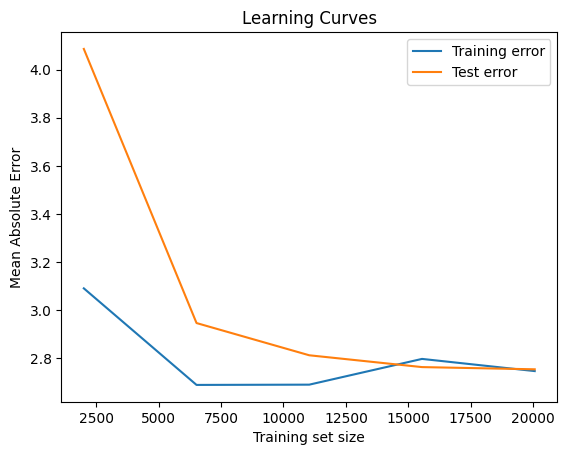

In [141]:
train_sizes, train_scores, test_scores = learning_curve(regressor, x_test, y_test, cv=5, scoring='neg_mean_absolute_error')

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

fig, ax = plt.subplots()
ax.plot(train_sizes, train_scores_mean, label='Training error')
ax.plot(train_sizes, test_scores_mean, label='Test error')
ax.set_xlabel('Training set size')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Learning Curves')
ax.legend()
plt.show()

## LSTM

In [142]:
prev_pred = 10
x_train, y_train = create_dataset(train, prev_pred=prev_pred)
x_test, y_test = create_dataset(test, prev_pred=prev_pred)

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [143]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, prev_pred)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=128, verbose=2)

Epoch 1/10
784/784 - 5s - loss: 0.0197 - 5s/epoch - 6ms/step
Epoch 2/10
784/784 - 2s - loss: 1.8515e-04 - 2s/epoch - 2ms/step
Epoch 3/10
784/784 - 2s - loss: 8.0263e-05 - 2s/epoch - 2ms/step
Epoch 4/10
784/784 - 2s - loss: 5.7164e-05 - 2s/epoch - 2ms/step
Epoch 5/10
784/784 - 2s - loss: 4.9307e-05 - 2s/epoch - 2ms/step
Epoch 6/10
784/784 - 2s - loss: 4.6149e-05 - 2s/epoch - 2ms/step
Epoch 7/10
784/784 - 2s - loss: 4.2814e-05 - 2s/epoch - 3ms/step
Epoch 8/10
784/784 - 2s - loss: 3.8809e-05 - 2s/epoch - 3ms/step
Epoch 9/10
784/784 - 2s - loss: 3.4425e-05 - 2s/epoch - 3ms/step
Epoch 10/10
784/784 - 2s - loss: 3.0177e-05 - 2s/epoch - 3ms/step


In [144]:
pred_LSTM = model.predict(x_test)

784/784 [==============================] - 2s 2ms/step


In [145]:
pred_LSTM = scaler.inverse_transform(pred_LSTM)
y_test = scaler.inverse_transform([y_test])

In [146]:
mae_test = mean_absolute_error(y_test[0], pred_LSTM[:, 0])
r2_test = r2_score(y_test[0], pred_LSTM[:, 0])
variance_test = explained_variance_score(y_test[0], pred_LSTM[:, 0])

print("MAE: ", mae_test)
print("R2-score: ", r2_test)
print("Variance score: ", variance_test)

MAE:  4.84435739291107
R2-score:  0.995799854785736
Variance score:  0.9959235447370868


In [147]:
result_LSTM = pd.DataFrame({'Actual': y_test.flatten(), 'pred_LSTM': pred_LSTM.flatten()})
result_LSTM['Difference'] = result_LSTM['pred_LSTM'] - result_LSTM['Actual']
result_LSTM

Actual    pred_LSTM  Difference
0      2560.320167  2559.939941   -0.380226
1      2635.679986  2621.166748  -14.513238
2      2560.250083  2560.758545    0.508462
3      2618.999964  2626.117676    7.117712
4      2560.189914  2558.771484   -1.418430
...            ...          ...         ...
25072  2322.549956  2332.532959    9.983003
25073  2394.030134  2400.704590    6.674456
25074  2320.469968  2329.166992    8.697025
25075  2394.030134  2400.704590    6.674456
25076  2320.469968  2330.418945    9.948978

[25077 rows x 3 columns]

In [148]:
fig_lstm = go.Figure()
fig_lstm.add_trace(go.Scatter(x=result_LSTM.index, y=result_LSTM['Actual'], mode='lines', name='Actual'))
fig_lstm.add_trace(go.Scatter(x=result_LSTM.index, y=result_LSTM['pred_LSTM'], mode='lines', name='pred_LSTM'))

fig_lstm.update_layout(
    title='Actual vs Predicted for LSTM',
    xaxis_title='Index',
    yaxis_title='Value',
    showlegend=True,
    legend=dict(x=0, y=1),
)

fig_lstm.show()


In [149]:
fig_difference = go.Figure()
fig_difference.add_trace(go.Scatter(x=result_LSTM.index, y=result_LSTM['Difference'], mode='lines', name='Difference'))

fig_difference.update_layout(
    title='Difference',
    xaxis_title='Index',
    yaxis_title='Difference',
    showlegend=True,
    legend=dict(x=0, y=1),
)

fig_difference.show()

# Random Forest:

In [150]:
prev_pred = 10
x_train, y_train = create_dataset(train, prev_pred=prev_pred)
x_test, y_test = create_dataset(test, prev_pred=prev_pred)

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [151]:
rf_model = RandomForestRegressor()

In [152]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1] * x_train.shape[2]))

rf_model.fit(x_train, y_train)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] * x_test.shape[2]))

rf_pred = rf_model.predict(x_test)

In [153]:
rf_pred = scaler.inverse_transform(rf_pred.reshape(-1, 1)).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [154]:
mae_rf = mean_absolute_error(y_test, rf_pred)
r2_rf = r2_score(y_test, rf_pred)
variance_rf = explained_variance_score(y_test, rf_pred)

print("Random Forest Results:")
print("MAE: ", mae_rf)
print("R2-score: ", r2_rf)
print("Variance score: ", variance_rf)

Random Forest Results:
MAE:  3.0992763863823543
R2-score:  0.9976795183031064
Variance score:  0.9976903016330507


In [155]:
result_RF = pd.DataFrame({'Actual': y_test.flatten(), 'RF_pred': rf_pred.flatten()})
result_RF['Difference'] = result_RF['RF_pred'] - result_RF['Actual']
result_RF

Actual      RF_pred  Difference
0      2560.320068  2560.060024   -0.260044
1      2635.679932  2621.501212  -14.178720
2      2560.250000  2560.277819    0.027819
3      2619.000000  2630.940091   11.940091
4      2560.189941  2560.101214   -0.088727
...            ...          ...         ...
25072  2322.550049  2322.218075   -0.331974
25073  2394.030029  2404.444580   10.414550
25074  2320.469971  2321.417974    0.948003
25075  2394.030029  2394.867975    0.837946
25076  2320.469971  2321.992098    1.522127

[25077 rows x 3 columns]

In [156]:
fig_RF = go.Figure()
fig_RF.add_trace(go.Scatter(x=result_RF.index, y=result_RF['Actual'], mode='lines', name='Actual'))
fig_RF.add_trace(go.Scatter(x=result_RF.index, y=result_RF['RF_pred'], mode='lines', name='RF_pred'))

fig_RF.update_layout(
    title='Actual vs Predicted for Random Forest',
    xaxis_title='Index',
    yaxis_title='Value',
    showlegend=True,
    legend=dict(x=0, y=1),
)

fig_RF.show()

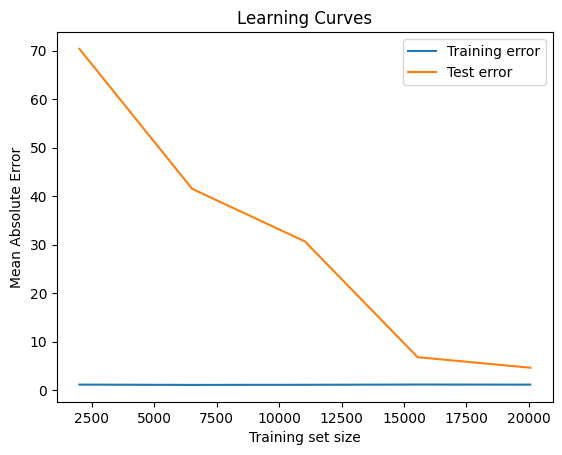

In [160]:
train_sizes, train_scores, test_scores = learning_curve(rf_model, x_test, y_test, cv=5, scoring='neg_mean_absolute_error')

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

fig, ax = plt.subplots()
ax.plot(train_sizes, train_scores_mean, label='Training error')
ax.plot(train_sizes, test_scores_mean, label='Test error')
ax.set_xlabel('Training set size')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Learning Curves')
ax.legend()
plt.show()

# Comparison of model results:

In [158]:
result = pd.DataFrame({'Actual': y_test.flatten(), 'LR_pred': linear_pred.flatten(), 
                       'LSTM_pred': pred_LSTM.flatten(), 'RF_pred': rf_pred.flatten()})
result 

Actual      LR_pred    LSTM_pred      RF_pred
0      2560.320068  2560.384277  2559.939941  2560.060024
1      2635.679932  2620.908936  2621.166748  2621.501212
2      2560.250000  2560.518555  2560.758545  2560.277819
3      2619.000000  2631.334961  2626.117676  2630.940091
4      2560.189941  2560.886475  2558.771484  2560.101214
...            ...          ...          ...          ...
25072  2322.550049  2321.239258  2332.532959  2322.218075
25073  2394.030029  2403.888672  2400.704590  2404.444580
25074  2320.469971  2322.650635  2329.166992  2321.417974
25075  2394.030029  2396.364502  2400.704590  2394.867975
25076  2320.469971  2320.359131  2330.418945  2321.992098

[25077 rows x 4 columns]

In [159]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=result.index, y=result['Actual'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=result.index, y=result['LR_pred'], mode='lines', name='LR_pred'))
fig.add_trace(go.Scatter(x=result.index, y=result['LSTM_pred'], mode='lines', name='LSTM_pred'))
fig.add_trace(go.Scatter(x=result.index, y=result['RF_pred'], mode='lines', name='RF_pred'))

fig.update_layout(
    title='Actual vs Predicted for Linear Regression',
    xaxis_title='Index',
    yaxis_title='Value',
    showlegend=True,
    legend=dict(x=0, y=1),
)

fig.show()